# Zillow Clustering Porject

### Executive Summary



Goals: Build a new regression model to predict logerror (log(Zestimate) - log(SalePrice)), and use clustering to see if we can find groups of similar observations to generate new features to be fed into our supervised model.

In [1]:
#imports
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score

import wrangle as w
import explore as e
import model as m

In [2]:
#get our data, turn into .csv, and check shape
df = w.get_zillow_data()
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,1727539,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1387261,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,11677,NaN,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,2288172,NaN,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,NaN,NaN,266.0,2.0,NaN,NaN,1.0,10887214,1970746,NaN,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77575 entries, 0 to 77574
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        222 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77575 non-null  float64
 3   heatingorsystemtypeid         49570 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      206 non-null    float64
 6   airconditioningtypeid         25006 non-null  float64
 7   parcelid                      77575 non-null  int64  
 8   id                            77575 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77575 non-null  float64
 11  bedroomcnt                    77575 non-null  float64
 12  buildingqualitytypeid         49809 non-null  float64
 13  c

Takeaways:

Lots of missing values
Some columns have inaccurate content?
Let's just clean it up for now, and we'll decide what we want to explore on later


Prepare our data for mostly-ready use. We're going to rename columns, make dummies, create new features, drop outliers, and drop columns and rows with more than 50% missing values.

In [4]:
#Clean zillow
df = w.prepare_zillow(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49727 entries, 0 to 77574
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   propertylandusetypeid       49727 non-null  float64
 1   parcel_id                   49727 non-null  int64  
 2   id                          49727 non-null  int64  
 3   baths                       49727 non-null  float64
 4   beds                        49727 non-null  float64
 5   calculatedbathnbr           49713 non-null  float64
 6   sqft                        49727 non-null  float64
 7   finishedsquarefeet12        49546 non-null  float64
 8   fullbathcnt                 49713 non-null  float64
 9   latitude                    49727 non-null  float64
 10  longitude                   49727 non-null  float64
 11  lotsizesquarefeet           49727 non-null  float64
 12  propertycountylandusecode   49727 non-null  object 
 13  rawcensustractandblock      497

In [6]:
#split into train, validate, test. Our target is logerror
train, validate, test = w.train_validate_test_split(df, 'logerror', seed=1234)

In [7]:
#return our train, validate, and test sets with calculatedbathnbr, fullbathcnt, regionidcity, regionidzip,censustractandblock
#imputed with most frequent values
train, validate, test = w.impute_nulls(train, validate, test, strategy='most_frequent', 
                        col_list=['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'censustractandblock'])

In [8]:
#return our train, validate, and test sets with finishedsquarefeet12, lotsizesquarefeet, structuretaxvaluedollarcnt, 
#tax_value, land tax value dollar count, and tax amount imputed with the column's median value. 
train, validate, test = w.impute_nulls(train, validate, test, strategy='median', 
                        col_list=['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 
                                  'tax_value', 'landtaxvaluedollarcnt', 'tax_amount'])

In [9]:
#drop rows with remaining nulls from all of our split sets
train = train.dropna()
validate = validate.dropna()
test = test.dropna()

In [10]:
#assuring there are no more nulls and we can almost get to work
train.isna().sum().sum(), validate.isna().sum().sum(), test.isna().sum().sum()

(0, 0, 0)

In [11]:
#total rows and columns that are left to work with 
#train should have most dataset
#47 columns
#we will touch test dataset at the end
train.shape, validate.shape, test.shape

((27805, 47), (11908, 47), (9932, 47))

In [12]:
#split new train, validate, and test into X_train, y_train, X_validate, y_validate, X_test, y_test with logerror as our target
X_train, y_train, X_validate, y_validate, X_test, y_test = w.split_X_y(train, validate, test, 'logerror')

In [13]:
#get object columns, and numeric columns so we can scale our data
obj_cols = w.get_object_cols(X_train)
num_cols = w.get_numeric_X_cols(X_train, obj_cols)

In [14]:
#scale our X_train, X_validate, and X_test with standard scaler
X_train_scaled, X_validate_scaled, X_test_scaled = w.standard_scale_data(X_train[num_cols],X_validate[num_cols],X_test[num_cols])

Takeaways:

Our data is now clean, and split.
We dropped any rows and columns with more than 50% missing values
Dropped, filled, or imputed for remaining missing values
We went from 77,575 rows to 49,727rows.
We had 68 columns, now 47.

## Explore
---
Hypothesis List


1.) Log error is affected by square footage, number of bedrooms and bathrooms.

2.) Log error is affected by property age

3.) Log error is affected by location

4.) Log error is affected by price per sq ft.

5.) Log error is affected by combinations of internal property features and combinations of locational features.



### univariate explore

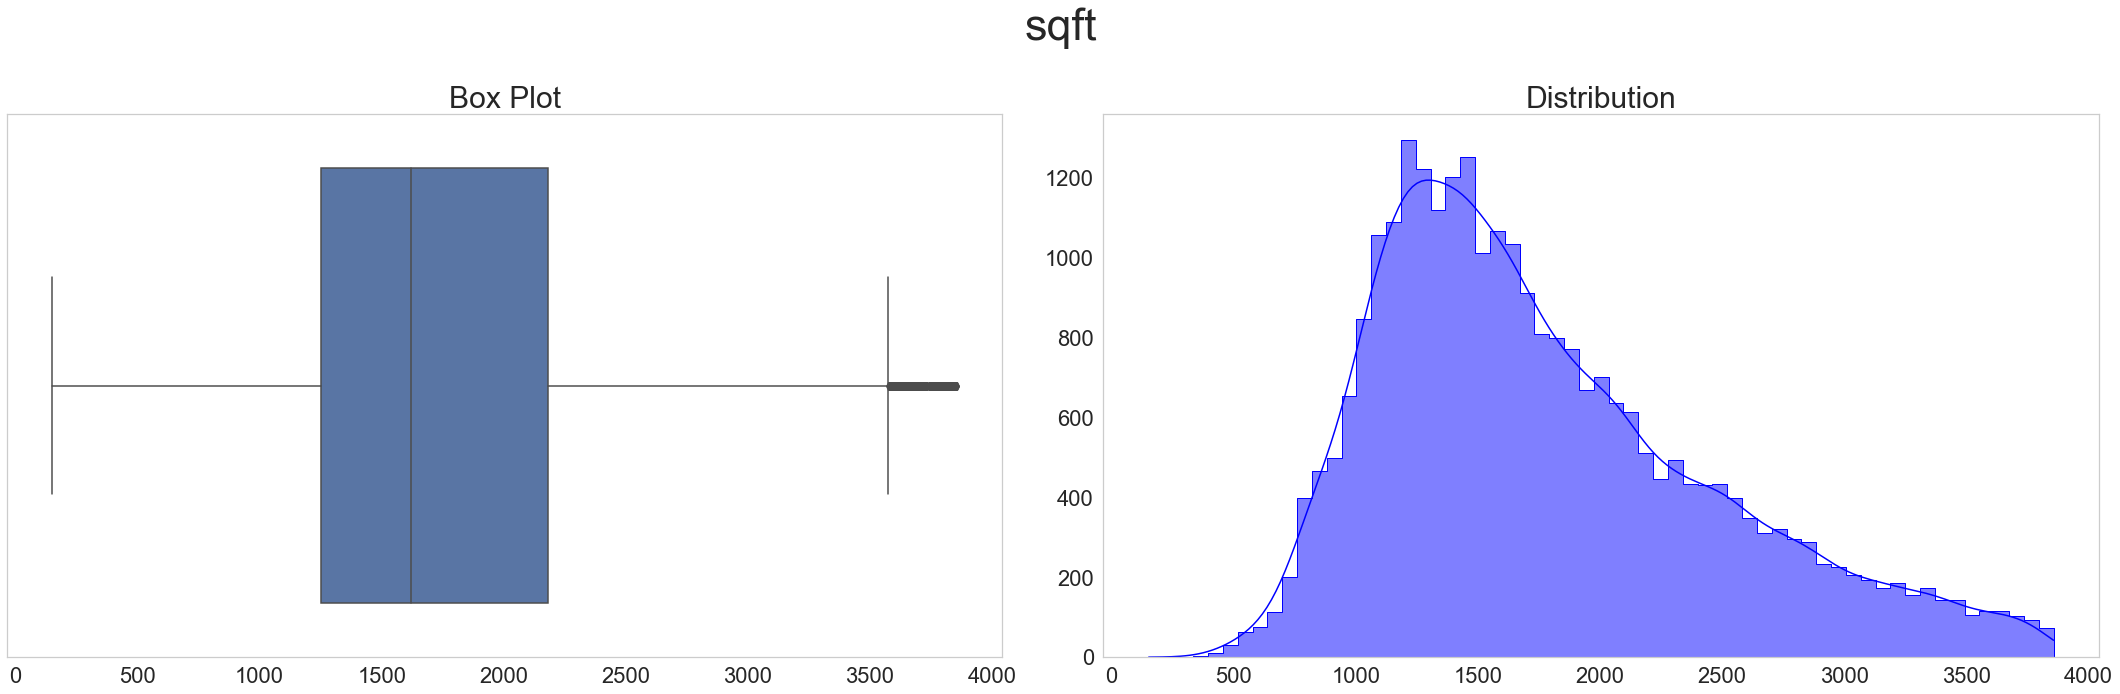

Summary Statistics for sqft
count    27805.000000
mean      1778.215429
std        695.838172
min        152.000000
25%       1252.000000
50%       1622.000000
75%       2181.000000
max       3857.000000
Name: sqft, dtype: float64


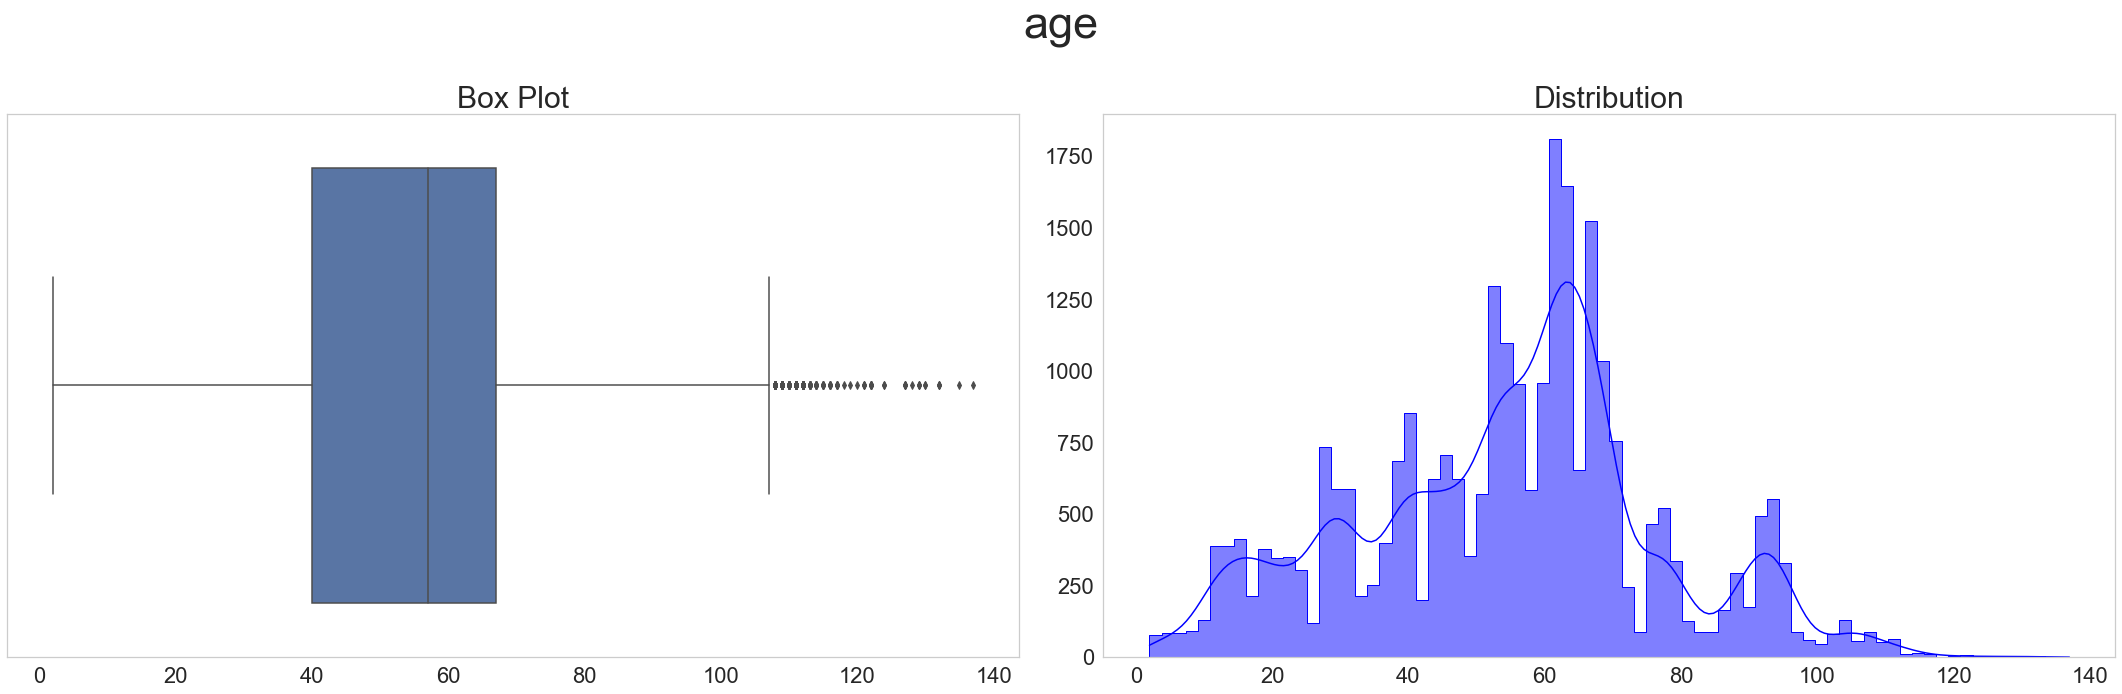

Summary Statistics for age
count    27805.000000
mean        54.604100
std         22.318244
min          2.000000
25%         40.000000
50%         57.000000
75%         67.000000
max        137.000000
Name: age, dtype: float64


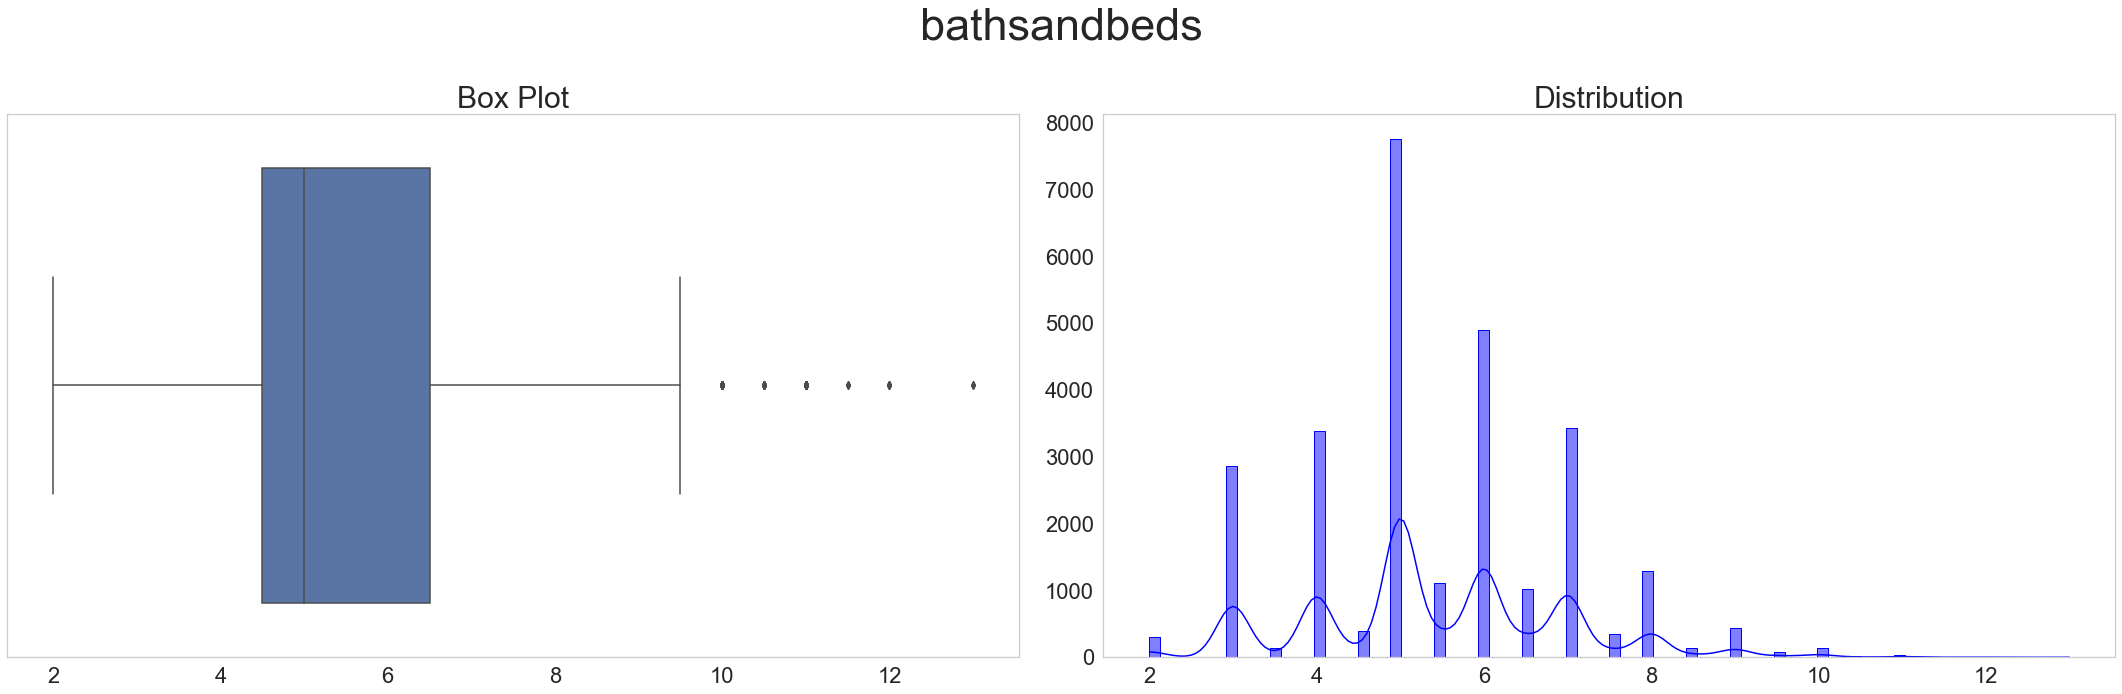

Summary Statistics for bathsandbeds
count    27805.000000
mean         5.430282
std          1.520902
min          2.000000
25%          4.500000
50%          5.000000
75%          6.500000
max         13.000000
Name: bathsandbeds, dtype: float64


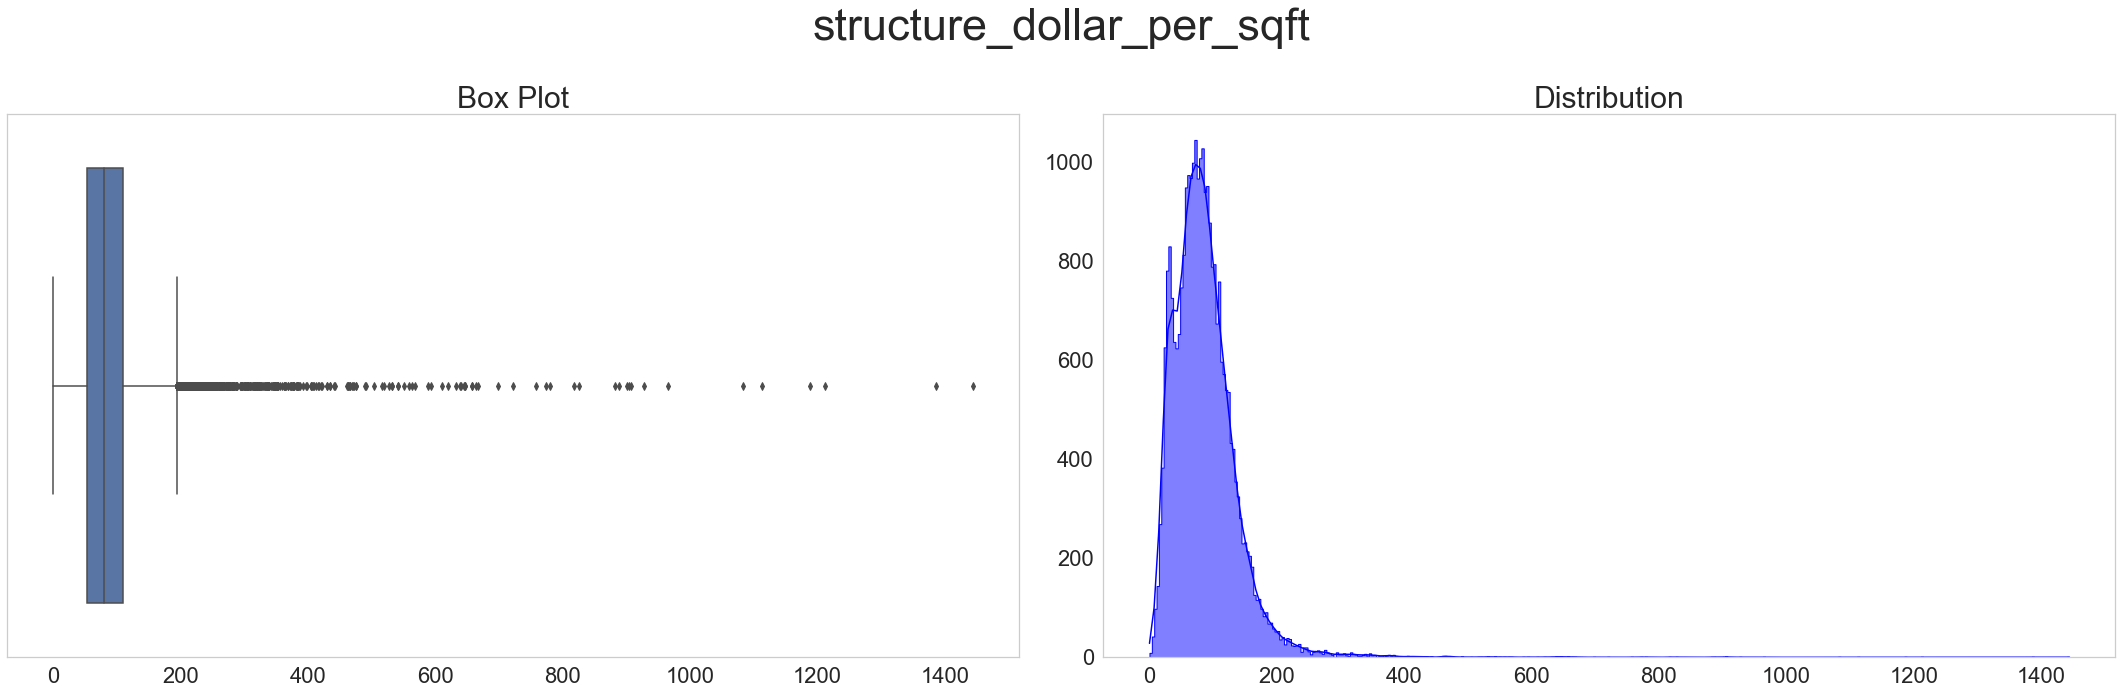

Summary Statistics for structure_dollar_per_sqft
count    27805.000000
mean        87.373581
std         55.942407
min          0.258741
25%         53.918586
50%         80.283942
75%        110.002174
max       1444.221106
Name: structure_dollar_per_sqft, dtype: float64


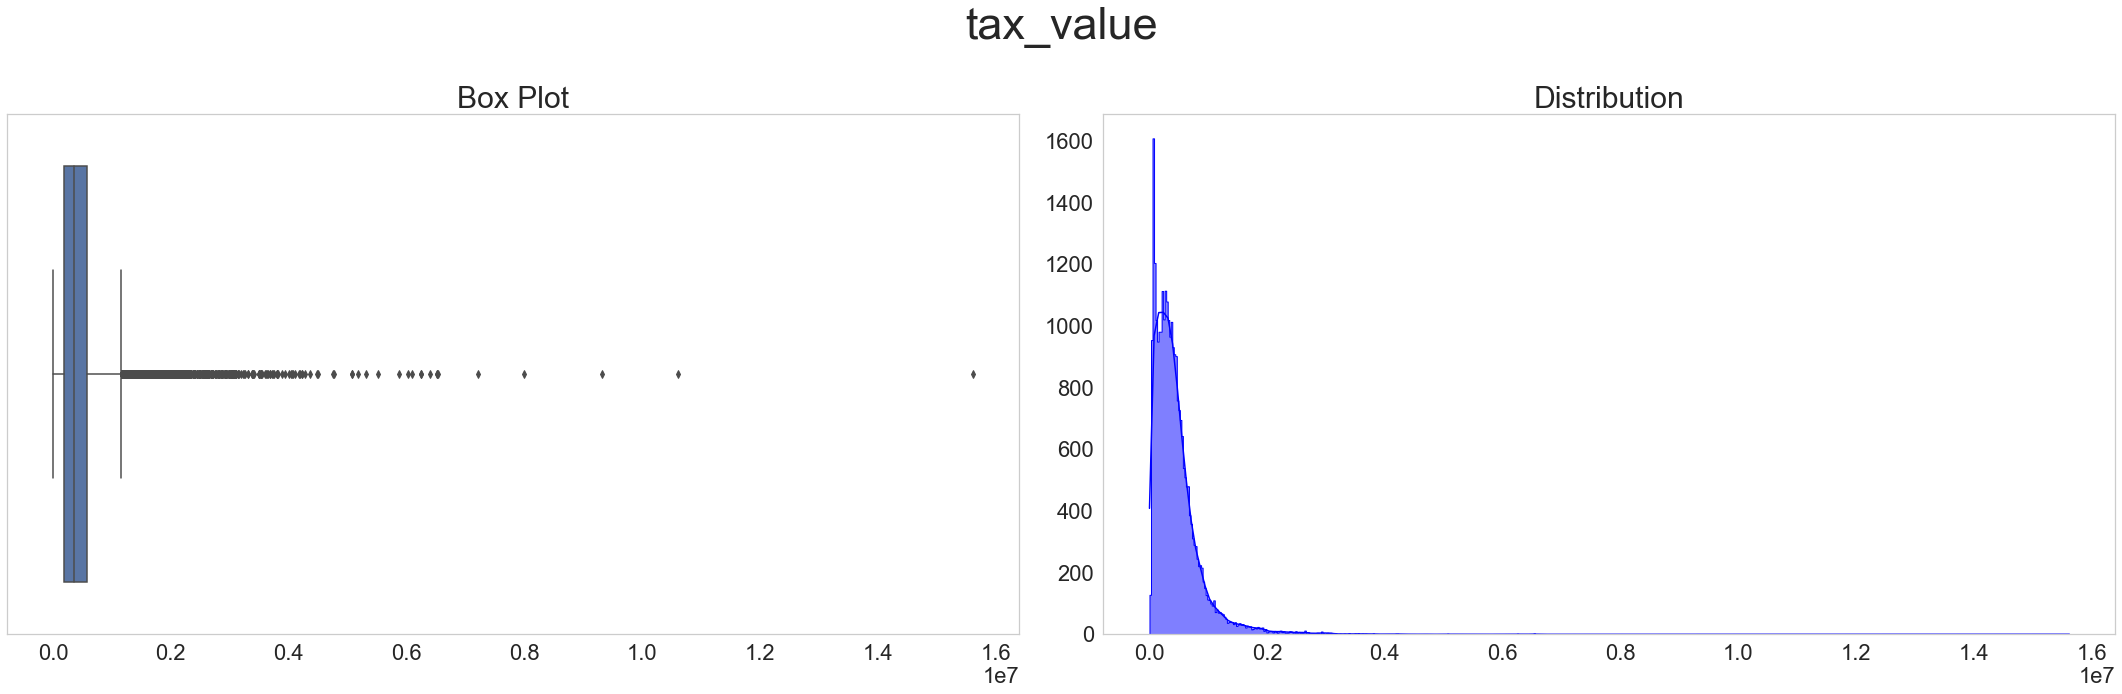

Summary Statistics for tax_value
count    2.780500e+04
mean     4.541208e+05
std      4.486173e+05
min      3.254000e+03
25%      1.866360e+05
50%      3.577080e+05
75%      5.772220e+05
max      1.561849e+07
Name: tax_value, dtype: float64


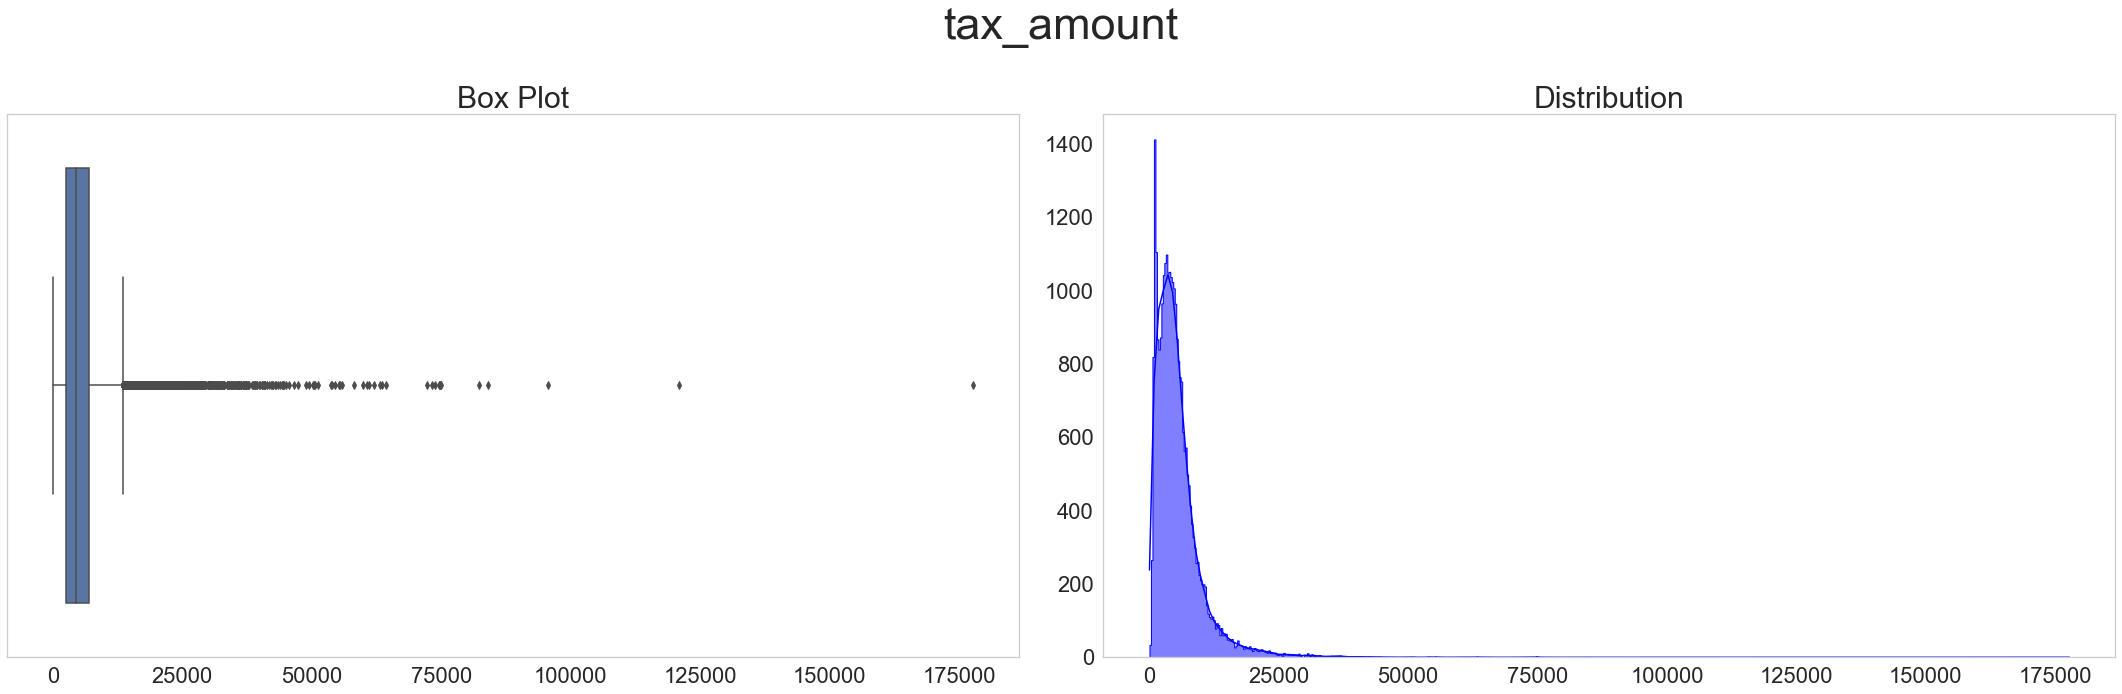

Summary Statistics for tax_amount
count     27805.000000
mean       5564.576977
std        5177.898600
min          49.180000
25%        2570.660000
50%        4462.460000
75%        6919.200000
max      177740.850000
Name: tax_amount, dtype: float64


In [15]:
univariate_e = ['sqft','age','bathsandbeds','structure_dollar_per_sqft','tax_value','tax_amount']

for i in univariate_e:
    e.explore_univariate(train, i)
    print(f'Summary Statistics for {i}\n{train[i].describe()}')

Takeaways for Univariate:

- Normal: number of bathrooms and bedrooms, latitude, and age
- Skewed right: tax amount, tax value, $ per sqft
- Skewed left: longitude


## Bivariate Exploration

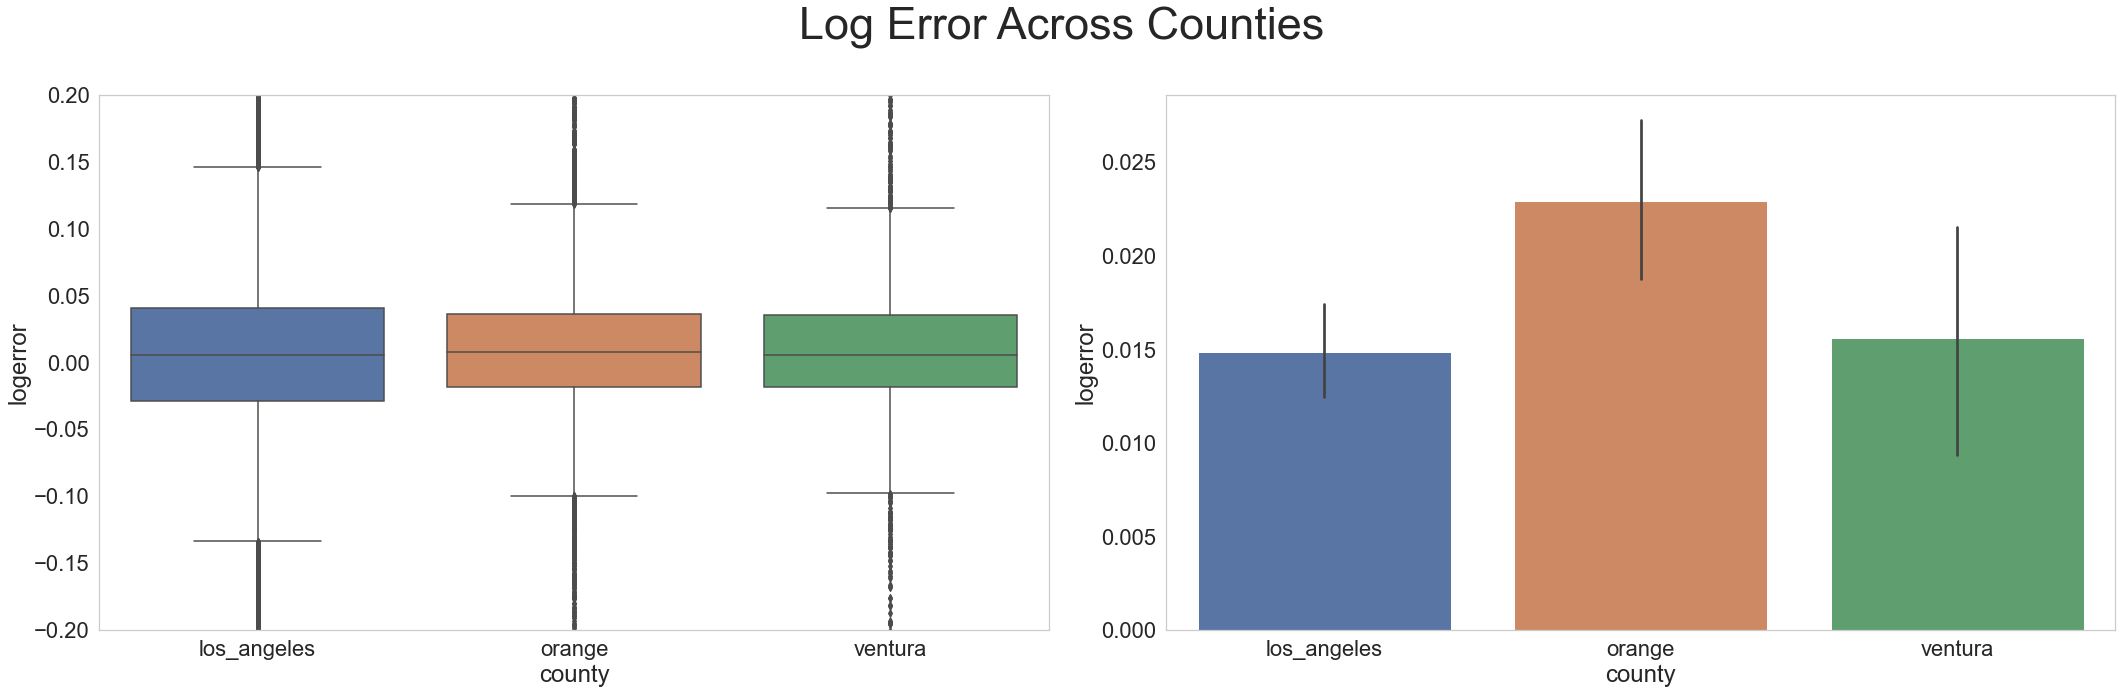

In [16]:
#logerror across counties (LA, Orange, and Ventura)

#set up figure size, font size, and turn off grid.
plt.figure(figsize=(30,10))
sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

#boxplot
plt.subplot(1, 2, 1)
sns.boxplot(train.county, train.logerror)
plt.ylim(-.2, .2)

#barplot
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='county',y='logerror')

#title
plt.suptitle('Log Error Across Counties', fontsize = 45)
plt.tight_layout()
plt.show()

## Stats

In [17]:
null_hypothesis = "no difference in logerror between orange county and the other counties"
alternative_hypothesis = "there is a difference in log error between orange county and other counties"
a = 0.05 #a for alpha 

orange_logerror=train[train.county=='orange'].logerror
other_logerror = train[train.county!='orange'].logerror
t, p = stats.ttest_ind(orange_logerror, other_logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between orange county and the other counties
There is evidence to suggest: there is a difference in log error between orange county and other counties


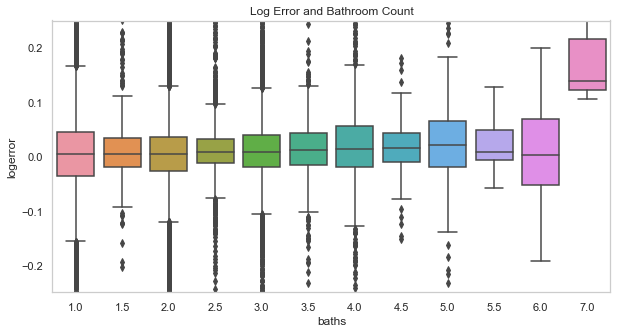

In [18]:
#Log error and number of bathrooms
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.boxplot(train.baths, train.logerror)
plt.title('Log Error and Bathroom Count')
plt.ylim(-.25, .25)
plt.show()

In [19]:
null_hypothesis = "no difference in logerror between properties with 3 bedrooms or less, or more bedrooms"
alternative_hypothesis = "there is a difference in logerror between properties with 3 bedrooms or less, or more bedrooms"
a = 0.05 #a for alpha 

three_or_less_beds=train[train.beds<=3].logerror
more_than_three_beds = train[train.beds>3].logerror
t, p = stats.ttest_ind(three_or_less_beds, more_than_three_beds)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties with 3 bedrooms or less, or more bedrooms
There is evidence to suggest: there is a difference in logerror between properties with 3 bedrooms or less, or more bedrooms


Sqft and LogError


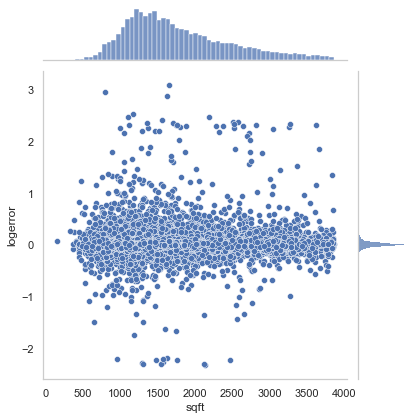

In [20]:
print('Sqft and LogError')
sns.jointplot(x='sqft', y='logerror', data=train)
plt.xlabel('Sqft')
plt.ylabel('Log Error')
plt.show()

In [21]:
alternative_hypothesis = "there is a difference in logerror between dollar per sqft"
a = 0.05 #a for alpha 

corr, p = stats.pearsonr(train.structure_dollar_per_sqft,train.logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties with 3 bedrooms or less, or more bedrooms
There is evidence to suggest: there is a difference in logerror between dollar per sqft


In [22]:
#let's add log error bins
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

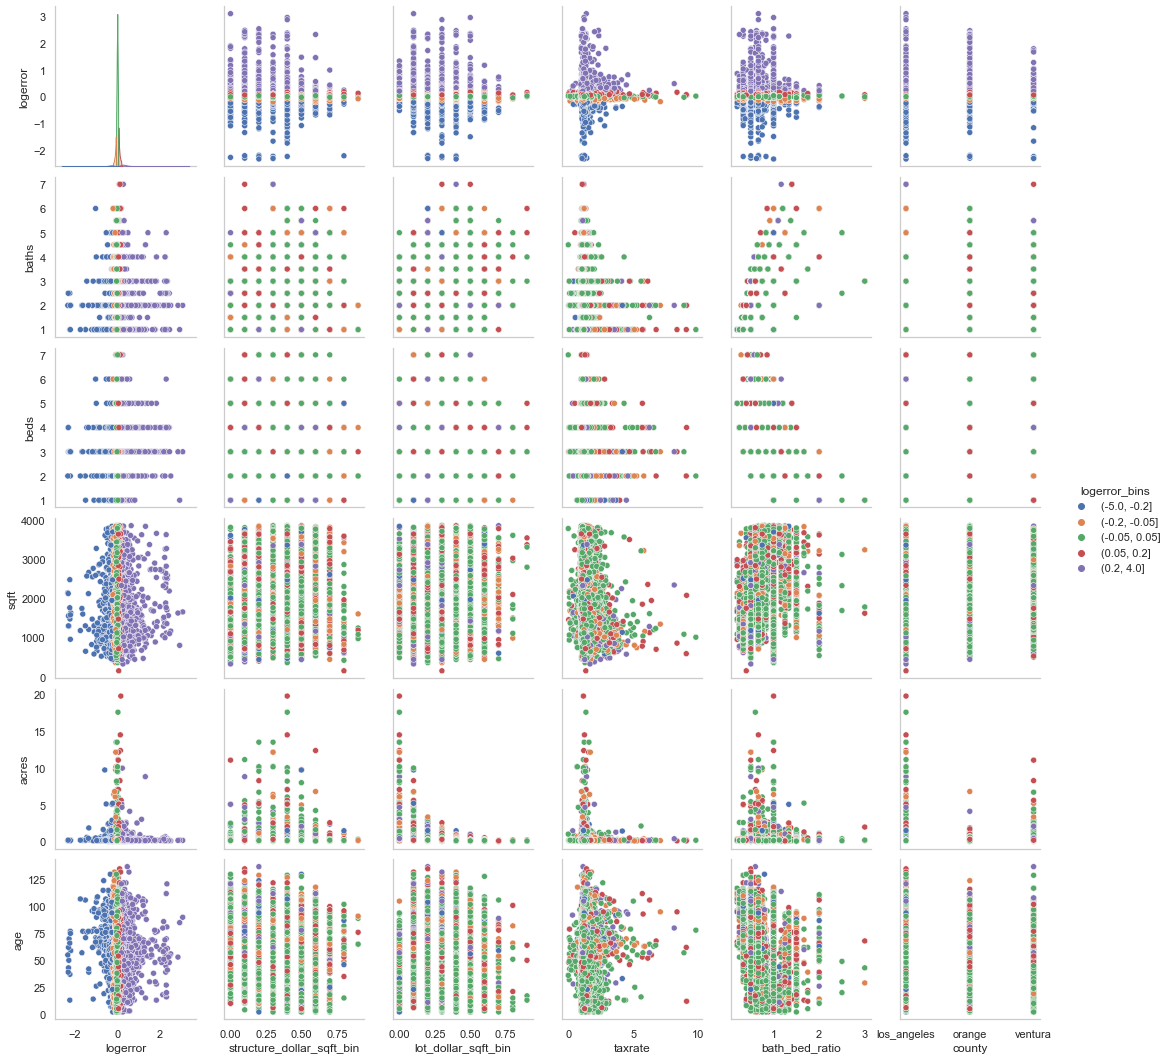

In [23]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror','structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio','county'],
             y_vars = ['logerror', 'baths','beds', 'sqft', 'acres', 'age'])

## Multivariate Exploration

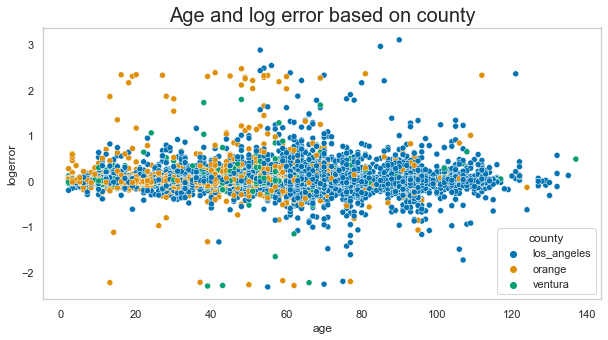

In [24]:
#age vs logerror based on county
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Age and log error based on county', fontsize=20)
plt.show()

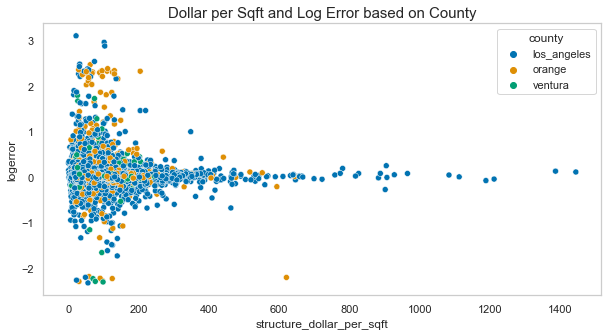

In [25]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on County', fontsize=15)
plt.show()

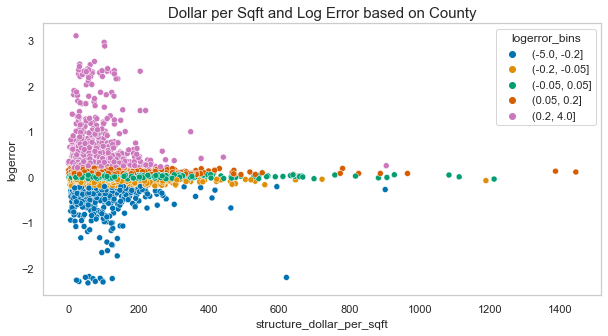

In [26]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='logerror_bins', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on County', fontsize=15)
plt.show()

## Data Explore with cluster

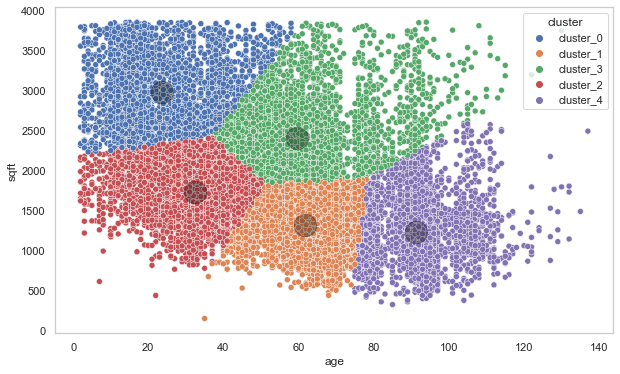

In [27]:
X = train[['age', 'sqft']]
df, X_scaled, scaler, kmeans, centroids = e.create_cluster(train, X, 5)
e.create_scatter_plot('age','sqft',train,kmeans, X_scaled, scaler)

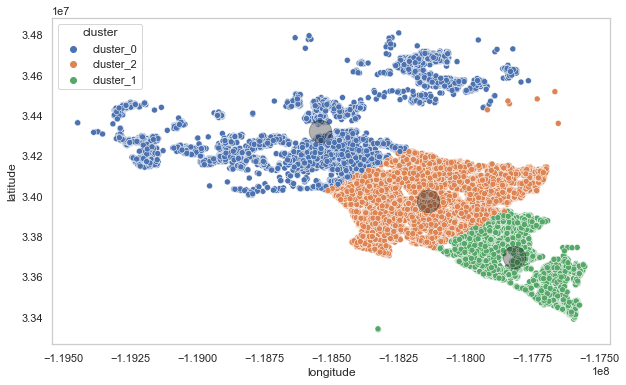

In [28]:
X = train[['longitude', 'latitude']]
df, X_scaled, scaler, kmeans, centroids = e.create_cluster(train, X, 3)
e.create_scatter_plot('longitude','latitude',train,kmeans, X_scaled, scaler)

In [29]:
X_features = train[['structure_dollar_per_sqft', 'age', 'bathsandbeds']]
X = X_train_scaled[['structure_dollar_per_sqft', 'age', 'bathsandbeds']]
#Callthe thing
kmeans = KMeans(n_clusters=5)

#Fit the thing
kmeans.fit(X)

#Use (predict using) the thing 
kmeans.predict(X)

X_train_scaled['cluster'] = kmeans.predict(X)
X_train_scaled.sample(5)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features.columns)

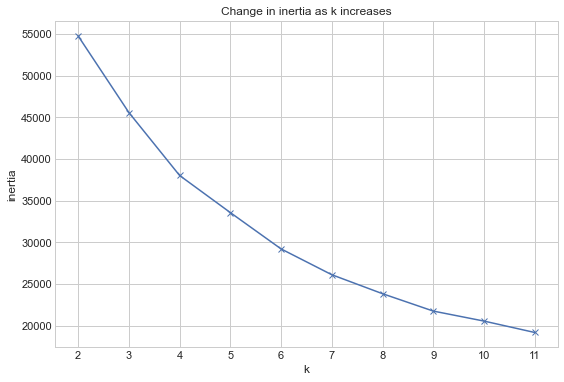

In [30]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

Take away:
- For cluster 'age', 'sqft' cluster 0 is a good candidate for modeling
- For cluster 'longtitude','latitude'  cluster 2 is a good candidate for modeling

## Model

In [31]:
#SELECT K BEST
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [32]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 2)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [33]:
# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')

,Var,Rank
4,beds,1
41,bathsandbeds,1
3,baths,2
24,Orange,3
38,los_angeles,4
40,ventura,5
23,LA,6
39,orange,7
25,Ventura,8
5,calculatedbathnbr,9


In [34]:
X_train_scaled = X_train_scaled.drop(columns='cluster')

In [35]:
number_of_features_list=np.arange(1,40)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 15
Score with 15 features: 0.002578


In [36]:
from sklearn.metrics import mean_squared_error, r2_score
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#logerror mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

#logerror_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

#RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('----------------------------------')

#RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('----------------------------------')
r2_baseline = r2_score(y_validate.logerror, y_validate.logerror_pred_mean)
print(f'The r^2 score for baseline is {round(r2_baseline,3)}')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  0.1663 
Validate/Out-of-Sample:  0.1798
----------------------------------
RMSE using Median
Train/In-Sample:  0.1667 
Validate/Out-of-Sample:  0.18
----------------------------------
The r^2 score for baseline is -0.0


In [37]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

In [38]:
selected_features = ['bathsandbeds', 'tax_value',
       'tax_amount', 'rawcensustractandblock',
       'structure_dollar_per_sqft', 'los_angeles', 'orange', 'ventura']

In [39]:

#Our first model: LinearRegression
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

#predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)


In [40]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)

In [41]:
#LassoLars
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

#predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)


In [42]:
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha = 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lars)}, ignore_index=True)

In [43]:
#TweedieRegressor
#create model object
glm = TweedieRegressor(power = 0,alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

#predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

In [44]:
metric_df = metric_df.append(
    {
    'model': 'GLM Model power 0',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_glm)}, ignore_index=True)

In [45]:
from sklearn.preprocessing import PolynomialFeatures

#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=3)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled, and X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled[selected_features])
X_test_degree2 = pf.transform(X_test_scaled[selected_features])

#linear regresson with 2 degrees
lm2 = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm2.fit(X_train_degree2,y_train.logerror)

#predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

#predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

In [46]:
metric_df = metric_df.append(
    {
    'model': 'Cubic Model',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm2)}, ignore_index=True)

In [47]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.180033,0.000000
1,OLS lm 1,0.179401,0.004033
2,LassoLars alpha = 1,0.179763,0.000000
3,GLM Model power 0,0.179503,0.002897
4,Cubic Model,0.179672,0.001035


In [48]:
# Take away
#Most of our 
#Our linear regression is the mvp, so i will test it how does it perform on unseen data
#turning it into a dataframe
y_test = pd.DataFrame(y_test)

# predicting on our test model
y_test['logerror_pred_lm'] = lm.predict(X_test_scaled[selected_features])

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm)**(1/2)
print('             ')
print('             Our Test Model')
print('----------------------------------')
print('----------------------------------')
print("RMSE for OLS Linear Regression Model \nOut-of-Sample Performance: ", rmse_test)
r2_test_score_lm = r2_score(y_test.logerror, y_test.logerror_pred_lm)
print(f'OLS Linear Regression has an R^2 value of {round(r2_test_score_lm,3)}')

             
             Our Test Model
----------------------------------
----------------------------------
RMSE for OLS Linear Regression Model 
Out-of-Sample Performance:  0.16429018463872147
OLS Linear Regression has an R^2 value of 0.002


In [49]:
#It does well compare to baseline